In [2]:
# Dependencies
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F

import datapipe
from basicsr.metrics import calculate_psnr, calculate_ssim
from basicsr.data import build_dataloader, build_dataset
from basicsr.data.degradations import add_jpg_compression
from basicsr.utils import FileClient, imfrombytes, img2tensor, tensor2img, scandir

# Compression Pipeline

The existing INDIGO+ model has a forward transform that downsamples the input image and a backward transform that upsamples the image. In a naive scheme where we simply apply INDIGO after JPEG encoding-decoding, the decoded JPEG image must be artificially downsampled to be used in the backward transform. This puts the INDIGO-enhanced scheme at a disadvantage as must work with less information, essentially capping the maximum RD performance at sub-baseline.

The goal of this section of the project is to generate a compression pipeline that has better rate-distortion performance than its baseline system (e.g. JPEG). We exploit the fact that the INN forward process learns a downsampling+compression degradation, meaning that we can apply downsampling prior to our chosen compression encoder in the sender side of the compression scheme. Through downsampling, we achieve a much lower bpp representation for transmission, which JPEG by itself will struggle to match with the same distortion level.

![Alt Text](figures/encoding_decoding_pipeline.png)

## Preparing Test Set

The test set is prepped by saving a 100 downsampled and compressed images that the inference script will restore. The dataloader carries out the role of the adapted encoder and JPEG decoder, which we hope to develop into a functions for a INDIGO compression class. The directory containing the degraded images also contains a json file that stores the size of their JPEG encoding vector.

In [3]:
%run inn/prep_test.py

AssertionError: An object named 'FFHQJPEGDataset' was already registered in 'dataset' registry!

In [4]:
with open("testdata/jpeg_qf10/69900.jpg", "rb") as f:
    jpeg_bytes = f.read()

print(len(jpeg_bytes))

FileNotFoundError: [Errno 2] No such file or directory: 'testdata/jpeg_qf10/69900.jpg'

## Inference

For inference, we can use the same inference script as before. The sampler has been adapted to accept smaller input images.

In [5]:
%run inference_compression.py \
    -i testdata/down_jpeg_qf0 -o results/down_jpeg_qf0 --task restoration \
    --eta 0.5 --aligned  --use_fp16 \
    --config_indigo configs/sample/indigo_syn_jpeg_qf0.yaml

KeyboardInterrupt: 

In [3]:
def calculate_bpp(shape, encsize=None, path=None):
    if (encsize is None):
        encsize = os.stat(path).st_size
    
    return encsize*8 / (shape[0]*shape[1]) # assumes HWC

def calculate_psnr_alt(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * (np.log10(abs(max_value) / (np.sqrt(mse)))).item()

def calculate_mse(img1, img2):
    return (np.mean((img1 - img2) ** 2)).item()

def calculate_rmse(img1, img2):
    return (np.sqrt(calculate_mse(img1, img2))).item()

results = dict()

## Scheme 0: Classic JPEG

In [4]:
gt_folder = 'datasets/ffhq/test'
file_client = FileClient('disk')

tmp = dict()
tmp['desc'] = 'Scheme 0: JPEG ENC => JPEG DEC'

qf = list(range(0, 100, 10))
scale = 2

print(tmp['desc'])

psnr = []
bpp = []

for factor in qf:
    paths = [os.path.join(gt_folder, v) for v in list(scandir(gt_folder))]
    
    psnr.append(0)
    bpp.append(0)
    
    for gt_path in paths:
    
        # Load gt images. Dimension order: HWC; channel order: BGR;
        # image range: [0, 1], float32.
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        # add JPEG compression
        img_lq, encsize = add_jpg_compression(img_hq, quality=factor, size = True)
        
        # BGR to RGB, HWC to CHW, numpy to tensor
        img_hq, img_lq = img2tensor([img_hq, img_lq], bgr2rgb=True, float32=True)
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255.
        
        img_hq, img_lq = tensor2img([img_hq, img_lq])
        
        # Calculate PSNR
        psnr[-1] += calculate_psnr_alt(img_hq, img_lq, img_hq.max())
    
        # Calculate BPP
        # Function works with HWC dimension ordering
        bpp[-1] += calculate_bpp(img_lq.shape, encsize=encsize.item())
    
    psnr[-1] = psnr[-1] / len(paths)
    bpp[-1] = bpp[-1] / len(paths)
    
    print(f"JPEG qf{factor} compression - PSNR {psnr[-1]} dB, BPP {bpp[-1]}")

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['0'] = tmp

Scheme 0: JPEG ENC => JPEG DEC


[ WARN:0@96.419] global loadsave.cpp:1329 imencode Unsupported depth image for selected encoder is fallbacked to CV_8U.


JPEG qf0 compression - PSNR 28.929774199393474 dB, BPP 0.16686798095703126
JPEG qf10 compression - PSNR 31.296199710857465 dB, BPP 0.265042724609375
JPEG qf20 compression - PSNR 32.9633113539531 dB, BPP 0.38778472900390626
JPEG qf30 compression - PSNR 33.81207414541621 dB, BPP 0.49850311279296877
JPEG qf40 compression - PSNR 34.352521910911065 dB, BPP 0.595843505859375
JPEG qf50 compression - PSNR 34.77655199883974 dB, BPP 0.6916702270507813
JPEG qf60 compression - PSNR 35.17245637353679 dB, BPP 0.7974566650390625
JPEG qf70 compression - PSNR 35.72119677657397 dB, BPP 0.9651593017578125
JPEG qf80 compression - PSNR 36.55124105919519 dB, BPP 1.245867919921875
JPEG qf90 compression - PSNR 38.35284454912664 dB, BPP 1.931898193359375


## Scheme 1: INDIGO-enhanced JPEG (w/o downsampling)

In [7]:
tmp = dict()
tmp['desc'] = 'Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/default/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['1'] = tmp

Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)
JPEG QF0 restoration - BPP 0.16686798095703126 	 PSNR 22.41760731935501 	 RMSE 0.07852946495509718
JPEG QF10 restoration - BPP 0.265042724609375 	 PSNR 27.472065234184264 	 RMSE 0.04466082697885491
JPEG QF20 restoration - BPP 0.38778472900390626 	 PSNR 28.132666420936584 	 RMSE 0.041535404606280135
JPEG QF30 restoration - BPP 0.49850311279296877 	 PSNR 28.67864856719971 	 RMSE 0.03908916562888481
JPEG QF40 restoration - BPP 0.595843505859375 	 PSNR 28.968861746788026 	 RMSE 0.03784241587654711
JPEG QF50 restoration - BPP 0.6916702270507813 	 PSNR 29.133503556251526 	 RMSE 0.03714923364631331
JPEG QF60 restoration - BPP 0.7974566650390625 	 PSNR 29.2837082862854 	 RMSE 0.03651308198358961
JPEG QF70 restoration - BPP 0.9651593017578125 	 PSNR 29.40541033744812 	 RMSE 0.03602295775628542
JPEG QF80 restoration - BPP 1.245867919921875 	 PSNR 29.491583704948425 	 RMSE 0.03568577457550711
JPEG QF90 restor

## Scheme 1.1: Larger training set

In [8]:
tmp = dict()
tmp['desc'] = 'Scheme 1.1: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/default_large/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['1.1'] = tmp

Scheme 1.1: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)
JPEG QF0 restoration - BPP 0.16686798095703126 	 PSNR 22.444534122943878 	 RMSE 0.07829630771119397
JPEG QF10 restoration - BPP 0.265042724609375 	 PSNR 26.807855319976806 	 RMSE 0.04805380315087426
JPEG QF20 restoration - BPP 0.38778472900390626 	 PSNR 28.121958899497987 	 RMSE 0.04158572790117988
JPEG QF30 restoration - BPP 0.49850311279296877 	 PSNR 28.67395145893097 	 RMSE 0.03911090737259915
JPEG QF40 restoration - BPP 0.595843505859375 	 PSNR 28.96446270942688 	 RMSE 0.03786209924829759
JPEG QF50 restoration - BPP 0.6916702270507813 	 PSNR 29.13243148326874 	 RMSE 0.03715462254117271
JPEG QF60 restoration - BPP 0.7974566650390625 	 PSNR 29.24981300830841 	 RMSE 0.03666581883672674
JPEG QF70 restoration - BPP 0.9651593017578125 	 PSNR 29.354776120185853 	 RMSE 0.036240690143305936
JPEG QF80 restoration - BPP 1.245867919921875 	 PSNR 29.44558207988739 	 RMSE 0.03588284642735327
JPEG QF90 rest

## Scheme 1.2: Larger training set and perceptual loss

In [9]:
tmp = dict()
tmp['desc'] = 'Scheme 1.2: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE+percep loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/default_large_percep/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['1.2'] = tmp

Scheme 1.2: JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE+percep loss)
JPEG QF0 restoration - BPP 0.16686798095703126 	 PSNR 22.955415153503417 	 RMSE 0.07388045830031581
JPEG QF10 restoration - BPP 0.265042724609375 	 PSNR 26.451067757606506 	 RMSE 0.050018934202909725
JPEG QF20 restoration - BPP 0.38778472900390626 	 PSNR 27.25498147010803 	 RMSE 0.04582299735768866
JPEG QF30 restoration - BPP 0.49850311279296877 	 PSNR 27.805256915092468 	 RMSE 0.04313581992040822
JPEG QF40 restoration - BPP 0.595843505859375 	 PSNR 28.116161274909974 	 RMSE 0.04168100531352558
JPEG QF50 restoration - BPP 0.6916702270507813 	 PSNR 28.286946177482605 	 RMSE 0.04089963209053944
JPEG QF60 restoration - BPP 0.7974566650390625 	 PSNR 28.413246512413025 	 RMSE 0.040319485405090394
JPEG QF70 restoration - BPP 0.9651593017578125 	 PSNR 28.57795593738556 	 RMSE 0.039570574525263635
JPEG QF80 restoration - BPP 1.245867919921875 	 PSNR 28.77566239833832 	 RMSE 0.038694233743199705
JP

## Scheme 2: INDIGO-enhanced JPEG (w/ downsampling)

In [10]:
tmp = dict()
tmp['desc'] = 'Scheme 2: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)'
print(tmp['desc'])

psnr = []
bpp = []

qf = range(0, 100, 10)
for quality in qf:
    with open(f'testdata/down_jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/down/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['2'] = tmp

Scheme 2: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)
JPEG QF0 restoration - BPP 0.0308026123046875 	 PSNR 19.390556895732878 	 RMSE 0.1112201421018781
JPEG QF10 restoration - BPP 0.0444940185546875 	 PSNR 24.854798948764802 	 RMSE 0.06018413431377927
JPEG QF20 restoration - BPP 0.05915740966796875 	 PSNR 26.026478171348572 	 RMSE 0.052880290541506184
JPEG QF30 restoration - BPP 0.0718359375 	 PSNR 26.464679980278014 	 RMSE 0.05041859241009223
JPEG QF40 restoration - BPP 0.08274200439453125 	 PSNR 26.705528950691225 	 RMSE 0.04912317290530135
JPEG QF50 restoration - BPP 0.09317657470703125 	 PSNR 26.877191710472108 	 RMSE 0.048217866408876875
JPEG QF60 restoration - BPP 0.10449310302734376 	 PSNR 27.0245423078537 	 RMSE 0.04742656833498776
JPEG QF70 restoration - BPP 0.12196044921875 	 PSNR 27.205939602851867 	 RMSE 0.04647234812933848
JPEG QF80 restoration - BPP 0.15024017333984374 	 PSNR 27.433603644371033 	 RMSE 0.045272716431679995
JPEG

NameError: name 'bpp0' is not defined

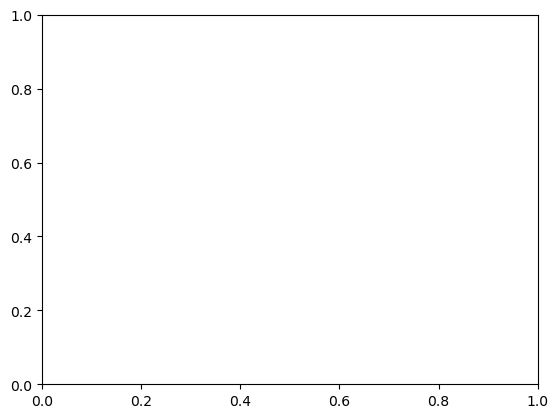

In [29]:
# Plot results
fig, ax = plt.subplots()
ax.plot(bpp0, psnr0, label='JPEG')
ax.plot(bpp1,psnr1, color='r', label='scheme')
ax.set_title('Rate-Distortion Performance')
ax.set_xlabel('bpp')
ax.set_ylabel('PSNR ($dB$)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.legend()
fig.show()   

The results above suggest that the INN is not learning the JPEG degradation process effectively. Furthermore, the downsampling scheme underperforms the naive scheme, meaning that providing a larger input for the initial prediction network is more impactful than the INN.

Next Steps:

* Larger training and validation sets
* Use perceptual loss such as LPIPS

## Scheme 2.1: Larger Training Set

In [12]:
# Profile our models
import json

tmp = dict()
tmp['desc'] = 'Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)'
print(tmp['desc'])

qf = range(10,100,10)
psnr = []
bpp = []
for quality in qf:
    with open(f'testdata/down_jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/down_large/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} restoration - BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['2.1'] = tmp

Scheme 2.1: down x4 => JPEG ENC => JPEG DEC => INDIGO (INN trained with large train set and MSE loss)
JPEG QF10 restoration - BPP 0.0444940185546875 	 PSNR 24.772856378555296 	 RMSE 0.0607057316417838
JPEG QF20 restoration - BPP 0.05915740966796875 	 PSNR 26.018643152713775 	 RMSE 0.05294607766265437
JPEG QF30 restoration - BPP 0.0718359375 	 PSNR 26.451445388793946 	 RMSE 0.050515339239282794
JPEG QF40 restoration - BPP 0.08274200439453125 	 PSNR 26.70150680541992 	 RMSE 0.0491687156347743
JPEG QF50 restoration - BPP 0.09317657470703125 	 PSNR 26.879808378219604 	 RMSE 0.04821773869095497
JPEG QF60 restoration - BPP 0.10449310302734376 	 PSNR 27.022880291938783 	 RMSE 0.0474571100101557
JPEG QF70 restoration - BPP 0.12196044921875 	 PSNR 27.203818988800048 	 RMSE 0.04649624608481043
JPEG QF80 restoration - BPP 0.15024017333984374 	 PSNR 27.446991634368896 	 RMSE 0.045211768464392385
JPEG QF90 restoration - BPP 0.21333892822265624 	 PSNR 27.752013206481934 	 RMSE 0.043711295868895036


## Scheme 2.2: Introducing Perceptual Loss

In [13]:
tmp = dict()
tmp['desc'] = 'Scheme 2.2: down x4 => JPEG ENC => JPEG DEC => INDIGO (percep loss + larger training set)'
print(tmp['desc'])

qf = range(0, 100, 10)
psnr = []
bpp = []

for quality in qf:
    with open(f'testdata/down_jpeg_qf{quality}/encsizes.json', "r") as f:
         encsizes = json.load(f)
    
    res_folder = f'results/jpeg_pipeline/down_large_percep/jpeg_qf{quality}/restored_faces'
    paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
    psnr.append(0)
    bpp.append(0)
    res_rmse = 0
    res_max = 0
    hq_max = 0
    for path in paths:
        img_bytes = file_client.get(path, 'res')
        img_res = imfrombytes(img_bytes, float32=True)
    
        img_name = os.path.splitext(os.path.basename(path))[0]
        gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
        img_bytes = file_client.get(gt_path, 'gt')
        img_gt = imfrombytes(img_bytes, float32=True)

        # generate lq image
        # downsample
        h, w = img_gt.shape[0:2]
        img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
        # Clamp both input and output
        
        # Calculate metrics
        psnr[-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
        bpp[-1] += calculate_bpp(img_hq.shape, encsize=encsizes[img_name])
        res_rmse += calculate_rmse(img_hq, img_res)
        
        # Record max
        res_max += img_res.max()
        hq_max += img_hq.max()

    bpp[-1] = bpp[-1] / len(paths)
    psnr[-1] = psnr[-1] / len(paths)
    res_rmse = res_rmse / len(paths)
    res_max = res_max / len(paths)
    hq_max = hq_max / len(paths)
    
    print(f'JPEG QF{quality} -  \t BPP {bpp[-1]} \t PSNR {psnr[-1]} \t RMSE {res_rmse}')

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['2.2'] = tmp

Scheme 2.2: down x4 => JPEG ENC => JPEG DEC => INDIGO (percep loss + larger training set)
JPEG QF0 -  	 BPP 0.0308026123046875 	 PSNR 19.92735723257065 	 RMSE 0.10461732492484793
JPEG QF10 -  	 BPP 0.0444940185546875 	 PSNR 24.74678100347519 	 RMSE 0.06079709072409095
JPEG QF20 -  	 BPP 0.05915740966796875 	 PSNR 25.891638886928558 	 RMSE 0.053581587028045934
JPEG QF30 -  	 BPP 0.0718359375 	 PSNR 26.474509739875792 	 RMSE 0.05026674427917654
JPEG QF40 -  	 BPP 0.08274200439453125 	 PSNR 26.800284790992738 	 RMSE 0.048506560125274524
JPEG QF50 -  	 BPP 0.09317657470703125 	 PSNR 27.008118772506712 	 RMSE 0.04742123261951791
JPEG QF60 -  	 BPP 0.10449310302734376 	 PSNR 27.172796654701234 	 RMSE 0.0465637300313537
JPEG QF70 -  	 BPP 0.12196044921875 	 PSNR 27.367343044281007 	 RMSE 0.04557205445650517
JPEG QF80 -  	 BPP 0.15024017333984374 	 PSNR 27.619076442718505 	 RMSE 0.04429509437414134
JPEG QF90 -  	 BPP 0.21333892822265624 	 PSNR 28.02461862564087 	 RMSE 0.042349106095222154


In [ ]:
# Plot results
fig, ax = plt.subplots()
ax.plot(bpp, psnr, label='JPEG')
ax.plot(res_bpp,res_psnr, color='r', label='large train set + percep')
ax.set_title('Rate-Distortion Performance')
ax.set_xlabel('bpp')
ax.set_ylabel('PSNR ($dB$)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.legend()
fig.show()   

## Scheme 3: JPEG (w/ downsampling & upsampling)

In [14]:
tmp = dict()
tmp['desc'] = 'Scheme 3: down x4 => JPEG ENC => JPEG DEC => up x4'
print(tmp['desc'])

psnr = []
bpp = []

dataset_opt = {
    'name': 'FFHQJPEGTest',
    'type': 'FFHQJPEGDataset',
    'phase': 'test',
    'gt_size': 512,
    'scale': 4,
    'encsize': True,
    'qf': 0,
    'dataroot_gt': 'datasets/ffhq/test',
    'io_backend':
        {'type': 'disk'} 
}

qf = range(0, 100, 10)
for factor in qf:
    dataset_opt['qf'] = factor
    test_set = build_dataset(dataset_opt)
    test_loader = build_dataloader(
                test_set,
                dataset_opt,
                num_gpu=1,
                dist=False,
                sampler=None,
                seed=0)
    
    psnr.append(0)
    bpp.append(0)
    for idx, val_data in enumerate(test_loader):
        img_hq = val_data['gt'] # 512x512
        img_lq = val_data['lq'] # 128x128
        encsize = val_data['encsize'].item()

        img_lq = F.interpolate(img_lq, 512, mode='bicubic', antialias=True)
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255.

        img_hq, img_lq = tensor2img([img_hq, img_lq])

        # Calculate PSNR
        psnr[-1] += calculate_psnr_alt(img_hq, img_lq, img_hq.max())
    
        # Calculate BPP
        # Function works with HWC dimension ordering
        bpp[-1] += calculate_bpp(img_lq.shape, encsize=encsize)

    psnr[-1] = psnr[-1] / len(test_set)
    bpp[-1] = bpp[-1] / len(test_set)

    print(f"JPEG qf{factor} - PSNR {psnr[-1]} dB, BPP {bpp[-1]}")

tmp['psnr'] = psnr
tmp['bpp'] = bpp
results['3'] = tmp

Scheme 3: down x4 => JPEG ENC => JPEG DEC => up x4
JPEG qf0 - PSNR 28.64533687567799 dB, BPP 0.0308026123046875
JPEG qf10 - PSNR 29.929654475729162 dB, BPP 0.0444940185546875
JPEG qf20 - PSNR 30.72310646408076 dB, BPP 0.05915740966796875
JPEG qf30 - PSNR 31.149437766593692 dB, BPP 0.0718359375
JPEG qf40 - PSNR 31.414946076847382 dB, BPP 0.08274200439453125
JPEG qf50 - PSNR 31.612481615752085 dB, BPP 0.09317657470703125
JPEG qf60 - PSNR 31.783947056700075 dB, BPP 0.10449310302734376
JPEG qf70 - PSNR 31.997702959032473 dB, BPP 0.12196044921875
JPEG qf80 - PSNR 32.27614880312219 dB, BPP 0.15024017333984374
JPEG qf90 - PSNR 32.73112713441064 dB, BPP 0.21333892822265624


## Rate-Distortion Curves

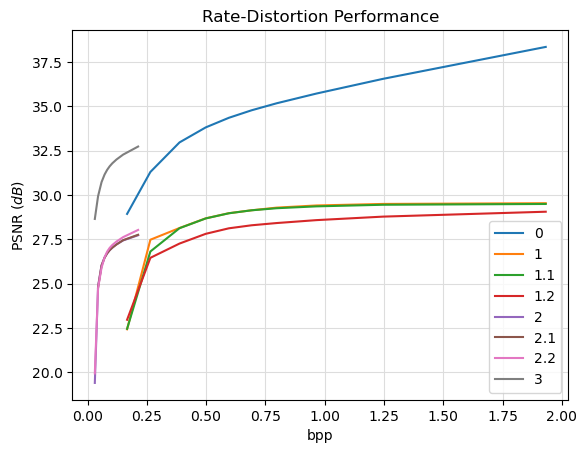

In [15]:
# Plot results
fig, ax = plt.subplots()
for key in results:
    ax.plot(results[key]['bpp'],results[key]['psnr'], label=key)
ax.set_title('Rate-Distortion Performance')
ax.set_xlabel('bpp')
ax.set_ylabel('PSNR ($dB$)')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.legend()
fig.show()   

In [16]:
fig.savefig('figures/rd_performance.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Bjontegaard-Delta Rate

In [43]:
import bjontegaard as bd

points = [0, 3, 6, 9]

rate_anchor = [results['2']['bpp'][p] for p in points]
psnr_anchor = [results['2']['psnr'][p] for p in points]
rate_test = [results['2.2']['bpp'][p] for p in points]
psnr_test = [results['2.2']['psnr'][p] for p in points]

print(rate_anchor)
print(rate_test)

bd_rate = bd.bd_rate(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')
bd_psnr = bd.bd_psnr(rate_anchor, psnr_anchor, rate_test, psnr_test, method='akima')

print(f"BD-Rate: {bd_rate:.4f} %")
print(f"BD-PSNR: {bd_psnr:.4f} dB")

[0.0308026123046875, 0.0718359375, 0.10449310302734376, 0.21333892822265624]
[0.0308026123046875, 0.0718359375, 0.10449310302734376, 0.21333892822265624]
BD-Rate: 7.6689 %
BD-PSNR: 0.1717 dB


## Save Results

In [42]:
# store results

print(json.dumps(results, indent=4))

with open('results/rd_performance.json', 'w') as f:
    json.dump(results, f)

{
    "0": {
        "desc": "Scheme 0: JPEG ENC => JPEG DEC",
        "psnr": [
            28.929774199393474,
            31.296199710857465,
            32.9633113539531,
            33.81207414541621,
            34.352521910911065,
            34.77655199883974,
            35.17245637353679,
            35.72119677657397,
            36.55124105919519,
            38.35284454912664
        ],
        "bpp": [
            0.16686798095703126,
            0.265042724609375,
            0.38778472900390626,
            0.49850311279296877,
            0.595843505859375,
            0.6916702270507813,
            0.7974566650390625,
            0.9651593017578125,
            1.245867919921875,
            1.931898193359375
        ]
    },
    "1": {
        "desc": "Scheme 1: JPEG ENC => JPEG DEC => INDIGO (INN trained with small train set and MSE loss)",
        "psnr": [
            22.41760731935501,
            27.472065234184264,
            28.132666420936584,
            2

## Consistency Step Hyperparameters

Extracted from `models/guided_diffusion.py`

```python
            y0_norm = y0 / 2 + 0.5
            cn, dn = self.model_inn.dae_f(x=out["pred_xstart"] / 2 + 0.5, cond=cond)
            x_0_hat01_opt = self.model_inn.dae_b(cn=y0_norm, dn=dn, cond=cond)
            difference_f = y0_norm - cn
            norm_f = th.linalg.norm(difference_f)
            norm_b_fea = iqa_loss(x_0_hat01_opt, (out["pred_xstart"] / 2 + 0.5))


            norm = self.configs_indigo.weight[0] * norm_f +self.configs_indigo.weight[1] * norm_b_fea


            norm_grad = th.autograd.grad(outputs=norm, inputs=img)[0]
            out["sample"] = out["sample"] - norm_grad * self.configs_indigo.scale
            img = out["sample"]
            img = img.detach_()
```

This is the data consistency step in action, where `self.configs_indigo.scale` is the step size parameter that controls how strongly the diffusion process is guided by the INN estimate. The hyperparameter `self.configs_indigo_weight` is an array length 2 which determines the weighting between losses `norm_f` and `norm_b_fea`.

In [1]:
zeta = [0,0.5,1,1.5,2,2.5,3,3.5]
qf = range(0,100,10)

psnr = []
for z in zeta:
    psnr.append([])
    for f in qf:
        res_folder = f'results/jpeg_pipeline/down_large_zeta{round(z*10)}/jpeg_qf{f}/restored_faces'
        paths = [os.path.join(res_folder, v) for v in list(scandir(res_folder))]
        psnr[-1].append(0)
        res_rmse = 0
        res_max = 0
        hq_max = 0
        for path in paths:
            img_bytes = file_client.get(path, 'res')
            img_res = imfrombytes(img_bytes, float32=True)
    
            img_name = os.path.splitext(os.path.basename(path))[0]
            gt_path = os.path.join(gt_folder, f'{img_name}.png')
    
            img_bytes = file_client.get(gt_path, 'gt')
            img_gt = imfrombytes(img_bytes, float32=True)

            # generate lq image
            # downsample
            h, w = img_gt.shape[0:2]
            img_hq = cv2.resize(img_gt, (512, 512), interpolation=cv2.INTER_CUBIC) # downsampling affects pixel value range
        
            # Clamp both input and output
        
            # Calculate metrics
            psnr[-1][-1] += calculate_psnr_alt(img_hq, img_res, img_hq.max())
            res_rmse += calculate_rmse(img_hq, img_res)
        
            # Record max
            res_max += img_res.max()
            hq_max += img_hq.max()

        psnr[-1][-1] = psnr[-1][-1] / len(paths)
        res_rmse = res_rmse / len(paths)
        res_max = res_max / len(paths)
        hq_max = hq_max / len(paths)
    
        print(f'JPEG QF10: PSNR {psnr[-1][-1]} RMSE {res_rmse}')#

for i,z in enumerate(zeta):
    plt.plot(qf,psnr[i],label=f'zeta={z}')
plt.show()

NameError: name 'scandir' is not defined